In [21]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import math

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data as data
from math import isnan
import math
import matplotlib.pyplot as plt

from argparse import Namespace
import pandas,pickle,warnings
warnings.filterwarnings("ignore")

from src.models import *
from src.utils import *
import argparse
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from src.dataloader import TabDataset
from src.models import *


from src import eval_utils
import time
from sklearn.manifold import TSNE 
from aif360.datasets import AdultDataset, GermanDataset, BankDataset, CompasDataset, BinaryLabelDataset
from sklearn.preprocessing import scale, StandardScaler, MaxAbsScaler

min_max_scaler = MaxAbsScaler()
std_scaler = StandardScaler()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(0)
#dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'bank': BankDataset(),'compas' : CompasDataset(),'celeb': CelebADataset()}
dataset = {'adult' : AdultDataset(), 'german' : GermanDataset(),'compas' : CompasDataset()}
dataset['german'].labels -= 1
sens_attr_dict = {'adult': ['sex', 'race'], 'german' : ['sex', 'age'], 'compas' : ['sex', 'race']}


In [12]:
data_name = 'adult'
protected_attribute_used = 1

In [13]:
if data_name == "adult":
    dataset_orig = AdultDataset()
    # #dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'

elif data_name == "german":
    dataset_orig = GermanDataset()
    # #dataset_orig.labels = #dataset_orig.labels-1
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'

elif data_name == "compas":
    dataset_orig = CompasDataset()
    # #dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        sens_attr = 'race'
    else:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        sens_attr = 'sex'
        

elif data_name == "bank":
    #dataset_orig = BankDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        sens_attr = 'age'
        
elif data_name == "meps":
    #dataset_orig = MEPSDataset19()
    privileged_groups = [{'RACE': 1}]
    unprivileged_groups = [{'RACE': 0}]
    sens_attr = 'RACE'

In [14]:
sens_idx = dataset[data_name].feature_names.index(sens_attr)
num_sens = len(np.unique(dataset[data_name].features[:, sens_idx]))

bs = 128
workers = 16
device = 'cuda:0'
hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}


feature_size = dataset[data_name].features.shape[1]
sens_loc = np.zeros(feature_size).astype(bool)
sens_loc[sens_idx] = 1

feature = dataset[data_name].features[:,~sens_loc] #data without sensitive
# feature = min_max_scaler.fit_transform(feature)
# feature = std_scaler.fit_transform(feature)
dataset[data_name].features[:,~sens_loc] = feature

#self.sensitive = dataset[data_name].features[:,sens_loc].reshape(-1).astype(int)
#n_values = int(np.max(self.label) + 1)
#self.label = np.eye(n_values)[self.label.astype(int)].squeeze(1)
# dataset[data_name], _ = dataset[data_name].split([0.5], shuffle=True)
data_train, data_vt = dataset[data_name].split([0.7], shuffle=True)
data_valid, data_test = data_vt.split([0.5], shuffle=True)

d_train = TabDataset(data_train, sens_idx)
v_train = TabDataset(data_valid, sens_idx)
t_train = TabDataset(data_test, sens_idx)

trainloader = torch.utils.data.DataLoader(
    d_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )

validloader = torch.utils.data.DataLoader(
    v_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )

testloader = torch.utils.data.DataLoader(
    t_train,
    batch_size=bs,
    shuffle=True,
    num_workers = 16
    )
input_dim = dataset[data_name].features.shape[1] - 1


In [15]:
parser = argparse.ArgumentParser("")
args = parser.parse_args("")

args.eta = 1e2
args.lamda = 1
args.alpha = 0.5
args.mu = 0.5

args.lr_h = 1e-4
args.lr_p = 1e-4

args.latent = 64
args.hidden = 64

In [16]:
epochs = 500

input_size = data_train.features.shape[1]-1
num_sens = len(np.unique(data_train.features[:, sens_idx]))
latent_size = args.latent
hidden_size = args.hidden

FIG_EPOCH = 100
VIEW_FIG = False
SAVE_MODEL = False
TEST_EPOCH = 5
VIEW_EVAL = False


eta = args.eta
lamda = args.lamda
alpha = args.alpha
mu = args.mu


In [17]:
def max_margin_loss(y_onehot, y_pred, theta=0.3, mu=0.3, lamda=1):
    # theta, mu in (0, 1]
    
    # sample margin
    margin = y_pred[y_onehot==1] - y_pred[y_onehot==0]
    # average margin
    margin_mean = nn.MultiMarginLoss()(y_pred, y_onehot.argmax(-1))
    
    # nn.ReLU()
    
    xi = torch.relu(1 - margin - theta)
    epsilon = torch.relu(margin - 1 - theta)

    margin_var = lamda * torch.mean((xi**2 + mu * epsilon ** 2)/((1-theta)**2))
    
    return margin_mean, margin_var


In [18]:
H = Feature_extractor(input_size, hidden_size, latent_size).double() # input_size -> 1024
P = Feature_predictor(latent_size, hidden_size, 2).double()
C = SVM(latent_size, 2).double() # 1024 -> 2   

H.apply(init_weights)
P.apply(init_weights)
C.apply(init_weights)

H = H.cuda()
P = P.cuda()
C = C.cuda()

optimizer = optim.Adam([{'params':H.parameters(), 'lr':1e-3, 'weight_decay':1e-5},
                       {'params':C.parameters(), 'lr':1e-3}])           
optimizerP = optim.Adam(P.parameters(), lr=1e-3, weight_decay=1e-5)

celoss = nn.functional.cross_entropy
svmloss = svm_loss
mmloss = max_margin_loss

Linear(in_features=97, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Dropout(p=0.3, inplace=False)
Feature_extractor(
  (dense1): Linear(in_features=97, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=2, bias=True)
Feature_predictor(
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=64, bias=True)
  (dense5): Linear(in_features=64, out_features=64, bias=True)
  (dense6): Linear(in_features=64, out_

In [19]:
epochs = 500
gamma = 1e0
gamma = 0.
eta = 1
theta = 0.5

for epoch in range(epochs+1):        
    start = time.time()
    cnt, count, acc = 0.,0., 0.
    loss_hist = 0
    loss_w_hist = 0
    loss_mm_hist = 0
    loss_ar_hist = 0
    loss_P_hist = 0
    margin_mean_hist = 0
    margin_var_hist = 0
        
    for x_batch, a_batch, y_batch in trainloader:
        x_batch, a_batch, y_batch = x_batch.cuda(), a_batch.cuda(), y_batch.cuda()
        a_onehot =  F.one_hot(a_batch, num_sens)
        y_onehot = F.one_hot(y_batch, 2)
        

        priv_idx = (a_batch==1).squeeze()
        positive_idx = y_batch==1

        ##############################
        ####### train Predictor ######
        ##############################
        optimizerP.zero_grad()

        latent = H(x_batch.detach())
        sens = P(latent)          

        loss_P = celoss(sens, a_batch.long())
        loss_P.backward()

        optimizerP.step()

        ##############################
        ####### train Extractor & Classifier #####
        ##############################
        optimizer.zero_grad()

        latent = H(x_batch)
        sens, pred = P(latent), C(latent)

        w = C.dense1.weight
        loss_w = torch.sum(w * w)
        m_mean, m_var = max_margin_loss(y_onehot.detach(), pred, theta = theta, mu = 0.3)
        loss_mm = gamma * m_mean + m_var
        
        a_r = torch.zeros_like(a_onehot).float().detach()
        a_r += 1 / num_sens
        
        loss_ar = torch.stack([cross_entropy(a_r[a_batch ==s], sens[a_batch ==s]) for s in range(2)]).mean()

        loss = 1e-4 * loss_w + loss_mm + eta * loss_ar
        loss.backward()

        optimizer.step() 

        loss_hist += loss.item()
        loss_w_hist += loss_w.item()
        loss_mm_hist += loss_mm.item()
        loss_ar_hist += loss_ar.item()
        margin_mean_hist += m_mean.item()
        margin_var_hist += m_var.item()
        loss_P_hist += loss_P.item()
        cnt += 1

    diag = "[TRAIN] epoch : [{}/{}]\n".format(epoch, epochs)
    diag += "Loss : {:.3f}, Loss P: {:.3f}\n".format(loss_hist/cnt, loss_P_hist/cnt)
    diag += "Loss w: {:.3f}, Loss mm: {:.3f}, Loss ar: {:.3f}\n".format(loss_w_hist/cnt, loss_mm_hist/cnt, loss_ar_hist/cnt)
    diag += "M mean : {:.3f}, M var : {:.3f}\n".format(margin_mean_hist/cnt, margin_var_hist/cnt)
    
    if epoch %100 == 0:
        print(diag)


[TRAIN] epoch : [0/500]
Loss : 1.219, Loss P: 0.632
Loss w: 4.150, Loss mm: 0.624, Loss ar: 0.595
M mean : 0.405, M var : 0.624

[TRAIN] epoch : [100/500]
Loss : 3.375, Loss P: 0.639
Loss w: 2.873, Loss mm: 0.496, Loss ar: 2.878
M mean : 0.302, M var : 0.496

[TRAIN] epoch : [200/500]
Loss : 3.365, Loss P: 0.638
Loss w: 2.497, Loss mm: 0.487, Loss ar: 2.878
M mean : 0.300, M var : 0.487

[TRAIN] epoch : [300/500]
Loss : 1.136, Loss P: 0.601
Loss w: 2.286, Loss mm: 0.600, Loss ar: 0.536
M mean : 0.269, M var : 0.600

[TRAIN] epoch : [400/500]
Loss : 3.280, Loss P: 0.638
Loss w: 2.164, Loss mm: 0.413, Loss ar: 2.867
M mean : 0.333, M var : 0.413

[TRAIN] epoch : [500/500]
Loss : 3.294, Loss P: 0.638
Loss w: 1.998, Loss mm: 0.415, Loss ar: 2.878
M mean : 0.326, M var : 0.415



In [20]:
H.eval()
C.eval()

with torch.no_grad():
    prob_lst, pred_lst, y_lst, a_lst = [], [], [], []
    for x_batch, s_batch, y_batch in validloader:
        x_batch, s_batch, y_batch = x_batch.cuda().double(), s_batch.cuda().float().view(-1,1), y_batch.cuda().float().view(-1,1)

        latent = H(x_batch)
        pred = C(latent).argmax(-1, keepdim = True)

        pred_lst.append(pred.detach())
        y_lst.append(y_batch.detach())
        a_lst.append(s_batch.detach())

    pred_lst = torch.cat(pred_lst).cpu().numpy()
    y_lst = torch.cat(y_lst).cpu().numpy()
    a_lst = torch.cat(a_lst).cpu().numpy()

    acc = (pred_lst == y_lst).mean()
    acc_priv = (pred_lst[a_lst == 1] == y_lst[a_lst == 1]).mean()
    acc_unpriv = (pred_lst[a_lst == 0] == y_lst[a_lst == 0]).mean()
    priv_idx = a_lst == 1
    pos_idx = y_lst == 1

    tpr = (pred_lst[pos_idx] == 1).mean()
    tpr_priv = (pred_lst[pos_idx*priv_idx] == 1).mean()
    tpr_unpriv = (pred_lst[pos_idx*~priv_idx] == 1).mean()

    fpr = (pred_lst[~pos_idx] == 1).mean()
    fpr_priv = (pred_lst[~pos_idx*priv_idx] == 1).mean()
    fpr_unpriv = (pred_lst[~pos_idx*~priv_idx] == 1).mean()

    DP = abs((pred_lst[priv_idx]==1).mean() - (pred_lst[~priv_idx]==1).mean())
    EOP =abs(tpr_priv-tpr_unpriv)
    EOD =abs(tpr_priv-tpr_unpriv) + abs(fpr_priv-fpr_unpriv)
    
    diag = "ACC : {:.3f}, ACC_priv : {:.3f}, ACC_unpriv : {:.3f}".format(acc, acc_priv, acc_unpriv)
    print(diag)

    diag = "TPR : {:.3f}, TPR_priv : {:.3f}, TPR_unpriv : {:.3f}".format(tpr, tpr_priv, tpr_unpriv)
    print(diag)

    diag = "FPR : {:.3f}, FPR_priv : {:.3f}, FPR_unpriv : {:.3f}".format(fpr, fpr_priv, fpr_unpriv)
    print(diag)

    diag = "DP : {:.3f}, EOP : {:.3f}, EOd : {:.3f}".format(DP, EOP, EOD)
    print(diag)

ACC : 0.851, ACC_priv : 0.817, ACC_unpriv : 0.923
TPR : 0.669, TPR_priv : 0.672, TPR_unpriv : 0.651
FPR : 0.089, FPR_priv : 0.117, FPR_unpriv : 0.043
DP : 0.180, EOP : 0.021, EOd : 0.095


In [16]:
y = data_vt.labels.reshape(-1)
a = data_vt.features[:,sens_loc]
a = a.reshape(-1)

idx = [[np.where((a == j) & (y==i))[0] for j in range(len(np.unique(a)))] for i in range(len(np.unique(y)))]
idx_len = [[len(np.where((a == j) & (y==i))[0]) for j in range(len(np.unique(a)))] for i in range(len(np.unique(y)))]
min_idx = np.min(idx_len)

[[np.random.shuffle(a_idx) for a_idx in y_idx] for y_idx in idx]

num_sample = min(min_idx, 200)

idx = [[a_idx[:num_sample] for a_idx in y_idx] for y_idx in idx]

idx = np.concatenate(idx).reshape(-1)

features = data_vt.features[idx]
sens = a[idx]
labels = data_vt.labels[idx]    



In [17]:
tsne = TSNE(n_jobs=16)

[0.5]
ACC_y: 0.578 


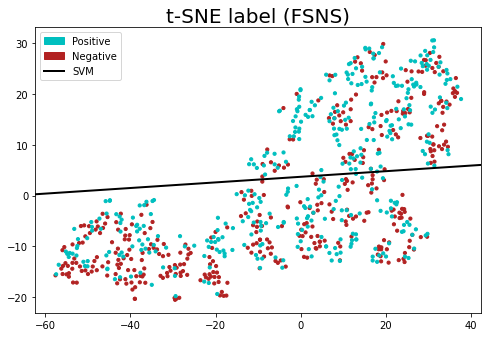

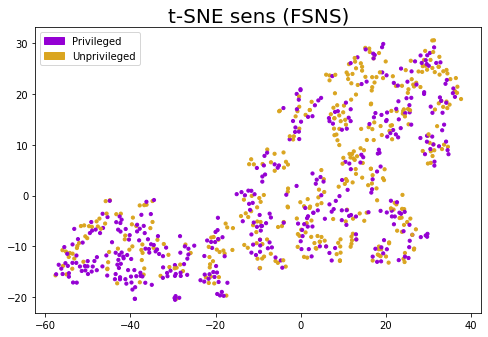

In [18]:
h = H(torch.tensor(features[:, ~sens_loc]).to(device))
h = h.cpu().detach().numpy()
h = StandardScaler().fit_transform(h) # normalizing the features

embedded = tsne.fit_transform(h)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]

print(sum(labels==1)/len(labels))

pop_a = mpatches.Patch(color='c', label='Positive')
pop_b = mpatches.Patch(color='firebrick', label='Negative')
#pop_c = mpatches.Arrow(color='black', label='SVM')

fig = plt.figure()
plt.scatter(vis_x, vis_y, c=np.array(['c' if i==1 else 'firebrick' for i in labels]), marker='.', s = 40)
x_lim = plt.gca().get_xlim()
y_lim = plt.gca().get_ylim()
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE label (FSNS)', fontsize = 20)

plt.tight_layout()
Fig = plt.gcf()
Fig.set_size_inches(7, 5, forward=True)

X = np.concatenate((vis_x.reshape(-1,1), vis_y.reshape(-1,1)), 1)
idx = np.array([i for i in range(len(X))])
np.random.shuffle(idx)
idx = idx[:int(len(idx)*0.75)]

svc = SVC(kernel='linear', C=500)
svc.fit(X[idx], labels[idx])

svm_pred = svc.predict(X[~idx])

print("ACC_y: {:.3f} ".format(sum(svm_pred == labels[~idx].reshape(-1))/len(labels[~idx])))

w = svc.coef_[0]
aa = -w[0] / w[1]
xx = np.linspace(x_lim[0], x_lim[1])
yy = aa * xx - svc.intercept_[0] / w[1]
y_lim = plt.gca().get_ylim()
plt.ylim(y_lim)
plt.xlim(x_lim)
svm = plt.plot(xx, yy, c='black', lw= 2, label = "SVM")
plt.legend(handles=[pop_a,pop_b, svm[0]])

# plt.savefig('fig/{}/tsne_label.png'.format(data_name))
plt.show()

pop_a = mpatches.Patch(color='darkviolet', label='Privileged')
pop_b = mpatches.Patch(color='goldenrod', label='Unprivileged')
#pop_c = mpatches.Arrow(color='black', label='SVM')

fig = plt.figure()
plt.scatter(vis_x, vis_y, c=np.array(['darkviolet' if i==1 else 'goldenrod' for i in sens]), marker='.', s = 40)
x_lim = plt.gca().get_xlim()
y_lim = plt.gca().get_ylim()
#plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.title('t-SNE sens (FSNS)', fontsize = 20)

plt.tight_layout()
Fig = plt.gcf()
Fig.set_size_inches(7, 5, forward=True)

X = np.concatenate((vis_x.reshape(-1,1), vis_y.reshape(-1,1)), 1)
idx = np.array([i for i in range(len(X))])
np.random.shuffle(idx)
idx = idx[:int(len(idx)*0.75)]

plt.legend(handles=[pop_a,pop_b])
plt.ylim(y_lim)
plt.xlim(x_lim)
# plt.savefig('fig/{}/tsne_sens.png'.format(data_name))
plt.show()
